In [20]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked
from mne.minimum_norm import apply_inverse, make_inverse_operator, get_point_spread, make_inverse_resolution_matrix
from mne.viz import plot_connectivity_circle
from mne.viz import circular_layout

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


Let's start importing some data

In [22]:
epoched = mne.read_epochs('sub-s01_task-faceFO_eeg.fif', verbose=False);

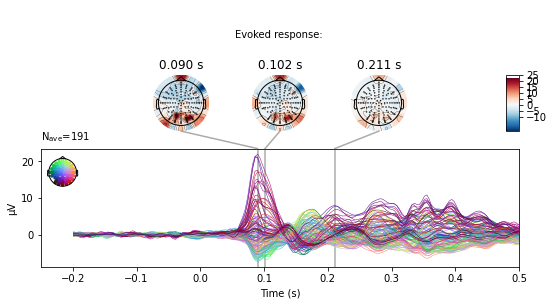

In [23]:
evoked = epoched.average()
evoked.set_eeg_reference('average', projection=True, verbose=False);
evoked.apply_baseline()
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.2)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.2, tmax=0.25)

times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(times=times, title='Evoked response: ', ts_args=ts_args);

## Source Analysis

Estimating brain activity at potentially thousands of brain locations (determined by the forward head model) from much fewer sensor locations is a so-called ill-posed inverse problem. One implication is that an infinite number of source activity patterns may explain equivalently well the sensor data. These aspects are explained in detail in: 

[https://www.nature.com/articles/nn.4504]

Such ill-posedness is not specific to EEG/MEG. It is quite typical in many other fields of science and engineering.

<img src="http://neuroimage.usc.edu/brainstorm/Tutorials/HeadModel?action=AttachFile&do=get&target=forward_inverse.gif" alt="Alternative text" />


##### Math of Source estimation

To compute source estimates, one typically assumes:
    
$$M = GX + E$$

where $M \in \mathbb{R}^{C \times T}$ is the sensor data, $G \in \mathbb{R}^{C \times S}$ is the lead-field (or gain) matrix, $X \in \mathbb{R}^{S \times T}$ is the source time course (stc) and $E \in \mathbb{R}^{C \times T}$ is additive Gaussian noise with zero mean and identity covariance


However, noise $E$ does not have identity covariance because of correlation between channels.
Thus, the noise covariance is computed empirically and made to be identity by "whitening"(more on this later ...)


Thus, the ingredients needed for source estimation are:
    
- the gain matrix $G$, computed during the forward calculation, which needs:
     - *Trans*: the coordinate transformation between head and MEG device
     - *Source space*: specifying the mesh on which we estimate the source current amplitudes
     - *Boundary element model (BEM)*: specifying the tissue profile and conductivity
- noise covariance matrix $EE{^\top}/T$

## Compute noise covariance

    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 3.4e-13 (2.2e-16 eps * 128 dim * 12  max singular value)
    Estimated rank (eeg): 127
    EEG: rank 127 computed from 128 data channels with 0 projectors


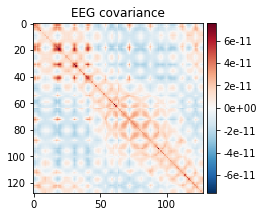

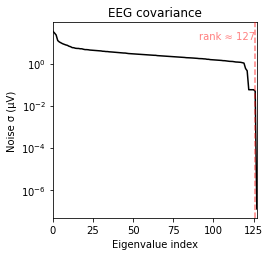

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [4]:
cov = mne.compute_covariance(epoched, method='auto', verbose=False)
cov.plot(epoched.info, proj=True)

## Compute and visualize BEM surfaces

The :term:`BEM` surfaces are the triangulations of the interfaces between
different tissues needed for forward computation. These surfaces are for
example the inner skull surface, the outer skull surface and the outer skin
surface, a.k.a. scalp surface.

Computing the BEM surfaces requires FreeSurfer and makes use of
the command-line tools `mne watershed_bem` or `mne flash_bem`, or
the related functions :func:`mne.bem.make_watershed_bem` or
:func:`mne.bem.make_flash_bem`.

Here we'll assume it's already computed. It takes a few minutes per subject.

For EEG we use 3 layers (inner skull, outer skull, and skin) while for
MEG 1 layer (inner skull) is enough.

Let's look at these surfaces. The function :func:`mne.viz.plot_bem`
assumes that you have the ``bem`` folder of your subject's FreeSurfer
reconstruction, containing the necessary surface files. Here we use a smaller
than default subset of ``slices`` for speed.



##### First we need to specify the freesurfer directory 

In [5]:
subjects_dir = r'/D:/Toronto/TMS_EEG/'
subject = 'MNI152_in_freesurfer'
os.environ['SUBJECTS_DIR'] = subjects_dir

The bem model has been already run for you because it takes time!! 

For creating your own source space you can use the line below: 


```
>>> conductivity = (0.3,)  # for single layer
>>> # conductivity = (0.3, 0.006, 0.3)  # for three layers
>>> model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
>>> bem = mne.make_bem_solution(model)

```



##### Then we are going to import the bem model (already computed for you it takes time!!!)

In [6]:
bem = mne.read_bem_solution('MNI152_in_freesurfer-bem',verbose=False)

Let’s look at these surfaces. The function mne.viz.plot_bem() assumes that you have the bem folder of your subject’s FreeSurfer reconstruction, containing the necessary surface files. Here we use a smaller than default subset of slices for speed.

Using surface: D:Toronto\TMS_EEG\MNI152_in_freesurfer\bem\inner_skull.surf
Using surface: D:Toronto\TMS_EEG\MNI152_in_freesurfer\bem\outer_skull.surf
Using surface: D:Toronto\TMS_EEG\MNI152_in_freesurfer\bem\outer_skin.surf


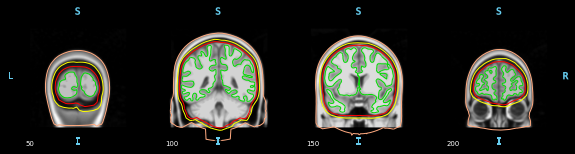

In [7]:

plot_bem_kwargs = dict(
    subject=subject, subjects_dir=subjects_dir,
    brain_surfaces='white', orientation='coronal',
    slices=[50, 100, 150, 200])

mne.viz.plot_bem(**plot_bem_kwargs);

## Visualizing the coregistration

The coregistration is the operation that allows to position the head and the
sensors in a common coordinate system. In the MNE software the transformation
to align the head and the sensors in stored in a so-called **trans file**.
It is a FIF file that ends with ``-trans.fif``. It can be obtained with
:func:`mne.gui.coregistration` (or its convenient command line
equivalent `mne coreg`), or mrilab if you're using a Neuromag
system.

Here we assume the coregistration is done, so we just visually check the
alignment with the following code.


In [8]:
subjects_dir = r'/D:/Toronto/TMS_EEG/MNI152_in_freesurfer/'
subject = 'MNI152_in_freesurfer'
os.environ['SUBJECTS_DIR'] = subjects_dir
#mne.gui.coregistration()

In [9]:
# The transformation file obtained by coregistration
trans = 'MNI152_in_freesurfer-trans.fif'
trans_mat = mne.read_trans(trans)
trans_mat

<Transform | head->MRI (surface RAS)>
[[ 0.99956191 -0.02390509 -0.01745241  0.00186592]
 [ 0.02296936  0.99838394 -0.05197945  0.00160757]
 [ 0.01866678  0.0515558   0.99849564 -0.05528704]
 [ 0.          0.          0.          1.        ]]

## Compute Source Space

The source space defines the position and orientation of the candidate source
locations. There are two types of source spaces:

- **surface-based** source space when the candidates are confined to a
  surface.

- **volumetric or discrete** source space when the candidates are discrete,
  arbitrarily located source points bounded by the surface.

**Surface-based** source space is computed using
:func:`mne.setup_source_space`, while **volumetric** source space is computed
using :func:`mne.setup_volume_source_space`.

We will now compute a surface-based source space with an ``'oct4'``
resolution. See `setting_up_source_space` for details on source space
definition and spacing parameter.

Already run for you because it takes time!! 

For creating your own source space you can use the line below: 


```
>>> src = mne.setup_source_space(subject, spacing='oct4', add_dist='patch',
                             subjects_dir=subjects_dir)

```

In [10]:
# Let's read the already computed source space

src = mne.read_source_spaces('MNI152_in_freesurfer-src.fif',verbose=False)
print(src)


<SourceSpaces: [<surface (lh), n_vertices=141637, n_used=4098>, <surface (rh), n_vertices=141124, n_used=4098>] MRI (surface RAS) coords, subject 'MNI152_in_freesurfer', ~25.0 MB>


Using surface: D:Toronto\TMS_EEG\MNI152_in_freesurfer\bem\inner_skull.surf
Using surface: D:Toronto\TMS_EEG\MNI152_in_freesurfer\bem\outer_skull.surf
Using surface: D:Toronto\TMS_EEG\MNI152_in_freesurfer\bem\outer_skin.surf


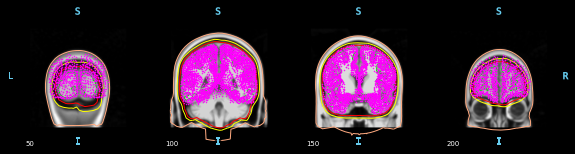

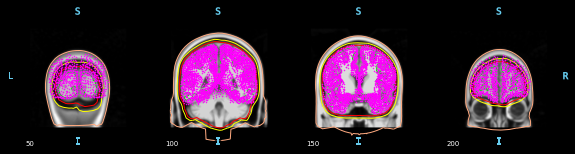

In [11]:
subjects_dir = r'/D:/Toronto/TMS_EEG/'
subject = 'MNI152_in_freesurfer'
os.environ['SUBJECTS_DIR'] = subjects_dir

plot_bem_kwargs = dict(
    subject=subject, subjects_dir=subjects_dir,
    brain_surfaces='white', orientation='coronal',
    slices=[50, 100, 150, 200])

mne.viz.plot_bem(src=src, **plot_bem_kwargs)

Now let’s see how to view all sources in 3D.

In [12]:
fig = mne.viz.plot_alignment(subject=subject, subjects_dir=subjects_dir,
                             surfaces='white', coord_frame='mri',
                             src=src)
mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
                    distance=0.30, focalpoint=(-0.03, -0.01, 0.03))

Using pyvistaqt 3d backend.



## Compute forward solution

We can now compute the forward solution.
To reduce computation we'll just compute a theree layers BEM
that can then be used for EEG (not MEG).
We specify if we want a one-layer or a three-layer BEM using the
``conductivity`` parameter.
The BEM solution requires a BEM model which describes the geometry
of the head the conductivities of the different tissues.


In [14]:
fwd = mne.make_forward_solution(epoched.info, trans=trans,
                                src=src, bem=bem, meg=False, eeg=True,
                                mindist=5.0, n_jobs=2, verbose=False)

We can explore the content of ``fwd`` to access the numpy array that contains the gain matrix.


In [15]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d channels x %d dipoles" % leadfield.shape)

Leadfield size : 128 channels x 23121 dipoles


To extract the numpy array containing the forward operator corresponding to
the source space ``fwd['src']`` with cortical orientation constraint
we can use the following:

In [16]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d channels x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 128 channels x 7707 dipoles


This is equivalent to the following code that explicitly applies the
forward operator to a source estimate composed of the identity operator
(which we omit here because it uses a lot of memory)::

    >>> import numpy as np
    >>> n_dipoles = leadfield.shape[1]
    >>> vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
    >>> stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices)
    >>> leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

To save to disk a forward solution you can use
:func:`mne.write_forward_solution` and to read it back from disk
:func:`mne.read_forward_solution`. Don't forget that FIF files containing
forward solution should end with :file:`-fwd.fif`.

To get a fixed-orientation forward solution, use
:func:`mne.convert_forward_solution` to convert the free-orientation
solution to (surface-oriented) fixed orientation.

## Inverse modeling with MNE and dSPM on evoked

Compute the inverse solution

In [17]:
inv = make_inverse_operator(epoched.info, forward=fwd, noise_cov=cov, verbose=False)
stc = apply_inverse(evoked, inv, method='dSPM', verbose=False) 

In [18]:
subjects_dir = r'/D:/Toronto/TMS_EEG/'
subject = 'MNI152_in_freesurfer'
os.environ['SUBJECTS_DIR'] = subjects_dir

stc.plot(hemi='both')

Using control points [ 5.50651968  6.15352595 12.58879785]


## Extract Labels

In [27]:
atlas2use = 'aparc.a2009s' #or Schaefer2018_200Parcels_7Networks_order

labels = mne.read_labels_from_annot(subject, parc=atlas2use,
                                    subjects_dir=subjects_dir)


n_labels = len(labels)
label_colors = [label.color for label in labels][:-2] #[1:201]
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels][:-2]  #[1:201]
lh_labels = [name for name in label_names if name.endswith('lh')]

rh_labels = [name for name in label_names if name.endswith('rh')]


# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label for (yp, label) in sorted(zip(label_ypos, rh_labels))]
#rh_labels = [label[:-2] + 'rh' for label in rh_labels]




# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])



Reading labels from parcellation...
   read 75 labels from D:Toronto\TMS_EEG\MNI152_in_freesurfer\label\lh.aparc.a2009s.annot
   read 75 labels from D:Toronto\TMS_EEG\MNI152_in_freesurfer\label\rh.aparc.a2009s.annot


In [29]:
label_stripped = []

#for xx in range(1,201):
for xx in range(0,148):

    label_stripped.append(labels[xx].name.replace('7Networks_',''))

    
label_ts = mne.extract_label_time_course(
    [stc], labels, src, mode='mean', allow_empty=True)[0]


Extracting time courses for 150 labels (mode: mean)


Link for the labels list:

[https://surfer.nmr.mgh.harvard.edu/fswiki/DestrieuxAtlasChanges

In [33]:
#indices = [i for i, s in enumerate(label_stripped) if 'Temp' in s]

#indices_temp = [i for i, s in enumerate(label_stripped) if "lh" in s and "Temp" in s]

#indices_pfc = [i for i, s in enumerate(label_stripped) if "lh" in s and "PFC" in s]

indices_temp = [i for i, s in enumerate(label_stripped) if "lh" in s and "fusi" in s]
indices_pfc = [i for i, s in enumerate(label_stripped) if "lh" in s and "G_front_middle" in s]


Where is located the label that we are going to use?!? Let's plot them on 
a surface with also the ``DestrieuxAtlasChanges``

In [44]:
Brain = mne.viz.get_brain_class()
brain = Brain(subject, 'both', 'inflated', subjects_dir=subjects_dir,
              cortex='low_contrast', background='white', size=(800, 600))
brain.add_annotation(atlas2use)
aud_label = [label for label in labels if label.name == 'G_oc-temp_lat-fusifor-lh'][0]
brain.add_label(aud_label, borders=False)

Extract the signal from the ROIs we have choosen 

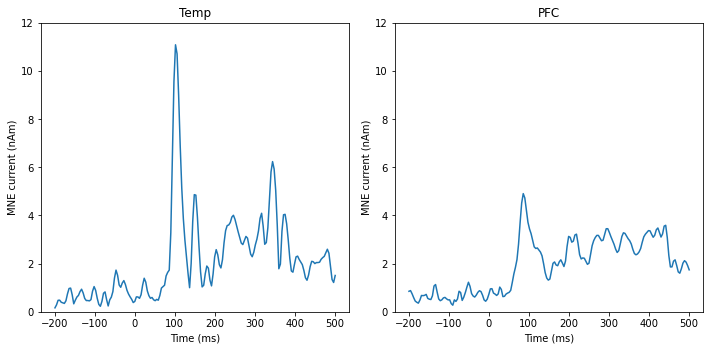

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

fig, axes = plt.subplots(1,2)

for pp in range(len(indices_temp)):
    axes[0].plot(1e3 * stc.times, label_ts[indices_temp[pp], :], label=label_stripped[indices_temp[pp]])
    axes[0].set(xlabel='Time (ms)', ylabel='MNE current (nAm)')
    axes[0].set_title('Temp')
    axes[0].set_ylim([0, 12])


for pp in range(len(indices_pfc)):
    axes[1].plot(1e3 * stc.times, label_ts[indices_pfc[pp], :], label=label_stripped[indices_pfc[pp]])
    axes[1].set(xlabel='Time (ms)', ylabel='MNE current (nAm)')
    axes[1].set_title('PFC')
    axes[1].set_ylim([0, 12])
    
#axes.legend()
mne.viz.tight_layout()

## Connectivity

<AxesSubplot:>

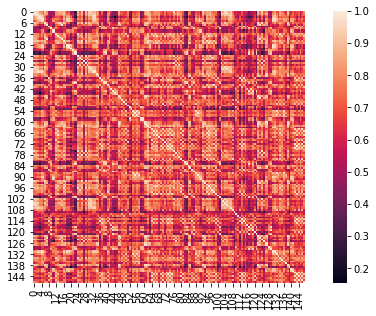

In [45]:
import seaborn as sns
sns.heatmap(np.corrcoef(label_ts[0:148,:]), square=True)

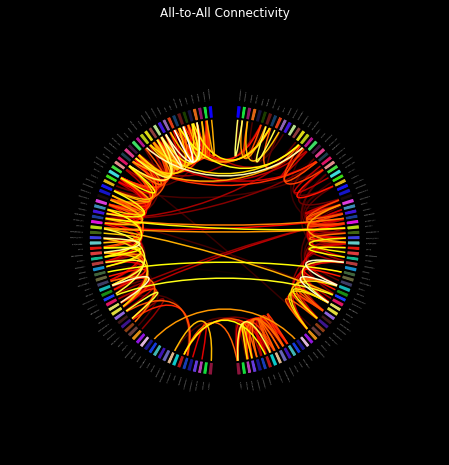

(<Figure size 576x576 with 1 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity'}>)

In [37]:
plot_connectivity_circle(np.corrcoef(label_ts[0:148,:]), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity', colorbar=False, fontsize_names=0)